In [1]:
sxz = "0. 0."
data_path = "data/vibro_seis/"
%run 2d_vibro/vibro_seis_elastic.py 50. 0. "../data/vibro_seis/recorders.txt" -gpu

Operator `initdamp` ran in 0.11 s


(110, 114) (np.float32(1.0), np.float32(1.0))
(64958, 1)


Operator `ForwardElastic` ran in 2.97 s


In [2]:
import numpy as np
import segyio
import matplotlib.pyplot as plt
from scratch.util import plot_seis_data
from scratch.devito_shared import gen_sweep, ricker_wavelet

In [3]:
with np.load("../results/vibro_elastic/vibro_full.npz") as f:
    data = f['data']
    dt = f['dt']
    sweep = f['sweep']
    rec_coords = np.loadtxt("../data/vibro_seis/recorders.txt")
    hits = gen_sweep(range(sweep.shape[0])*dt, [0.02,0.05])
    ricker = ricker_wavelet(0.06, dt)

In [4]:
np.savetxt("../results/vibro_elastic/hits.txt", hits)
np.savetxt("../results/vibro_elastic/ricker.txt", ricker)

In [7]:
path = '../results/vibro_elastic'
segyio.tools.from_array2D(path +'/2d_vibro_SRC-'+str(int(0))+'.sgy', data.T, dt=dt*10**3)
with segyio.open(path +'/2d_vibro_SRC-'+str(int(50))+'.sgy', 'r+') as f:
    for j in range(len(f.header)):
        f.header[j] = {segyio.TraceField.SourceGroupScalar : 1,
                        segyio.TraceField.SourceX : int(50),
                        segyio.TraceField.SourceDatumElevation : 0,
                        segyio.TraceField.GroupX : np.array(rec_coords[j, 0], dtype = int),
                        segyio.TraceField.ReceiverGroupElevation : 0
                        }

In [6]:
path = '../results/vibro_elastic'
segyio.tools.from_array(path +'/Sweep-20-50.sgy', sweep[np.newaxis, :], dt=dt*10**3)
# with segyio.open(path +'/Sweep-20-50.sgy', 'r+') as f:
#     for j in range(len(f.header)):
#         f.header[j] = {segyio.TraceField.SourceGroupScalar : 1,
#                         segyio.TraceField.SourceX : int(50),
#                         segyio.TraceField.SourceDatumElevation : 0,
#                         segyio.TraceField.GroupX : np.array(rec_coords[j, 0], dtype = int),
#                         segyio.TraceField.ReceiverGroupElevation : 0
#                         }

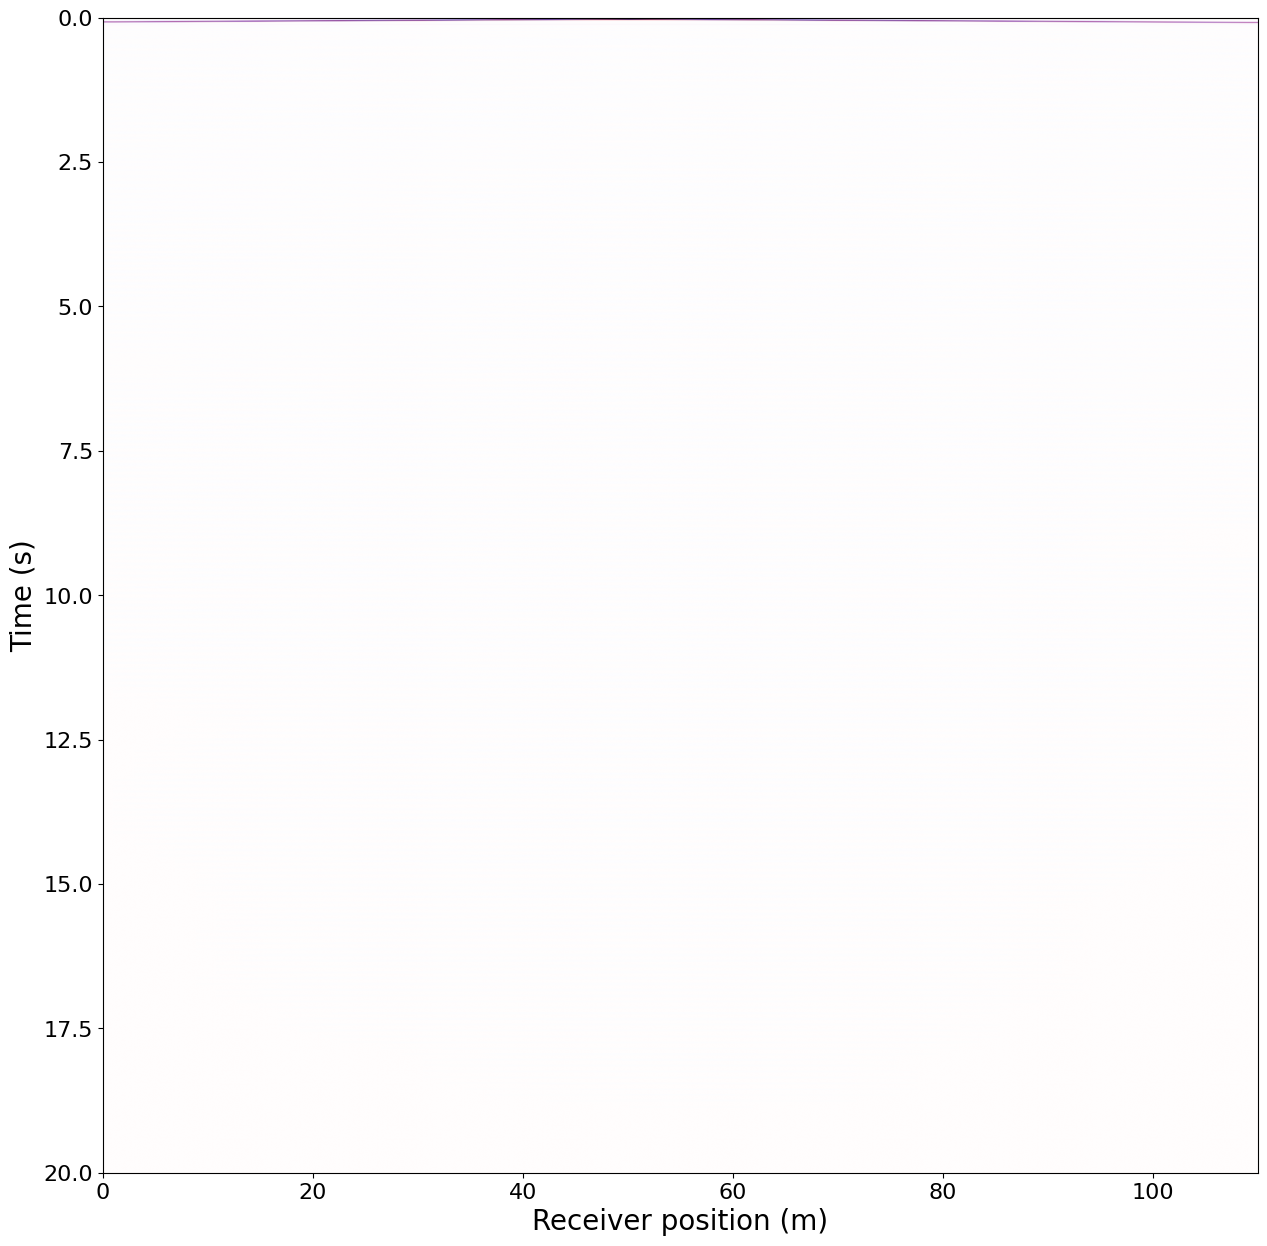

(0.0, 2.0)

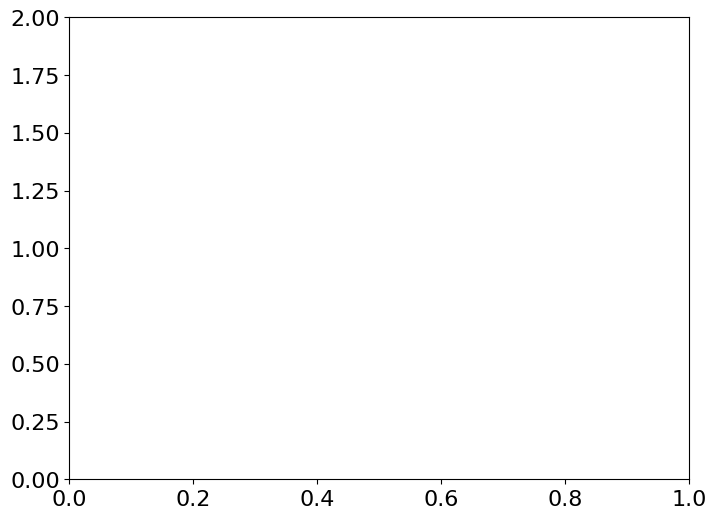

In [ ]:
def plot_seis_data(rec_coordinates, rec_data, t0: float, tn: float, gain = 2e1):
    #NBVAL_SKIP
    # Pressure (txx + tzz) data at sea surface
    extent = [rec_coordinates[0, 0], rec_coordinates[-1, 0], 1e-3*tn, t0]
    aspect = rec_coordinates[-1, 0]/(1e-3*tn)
    vminmax = np.max(np.abs(rec_data))
    sc = vminmax/gain
    plt.figure(figsize=(15, 15))
    plt.imshow(rec_data[::5,:], vmin=-sc, vmax=sc, cmap="seismic",
               interpolation='bilinear', extent=extent, aspect=aspect)
    plt.ylabel("Time (s)", fontsize=20)
    plt.xlabel("Receiver position (m)", fontsize=20)
    plt.show()
    plt.
plot_seis_data(rec_coords, data, 0, 20000)

# Коррелограмма трассы

<bound method Figure.tight_layout of <Figure size 2000x1000 with 2 Axes>>

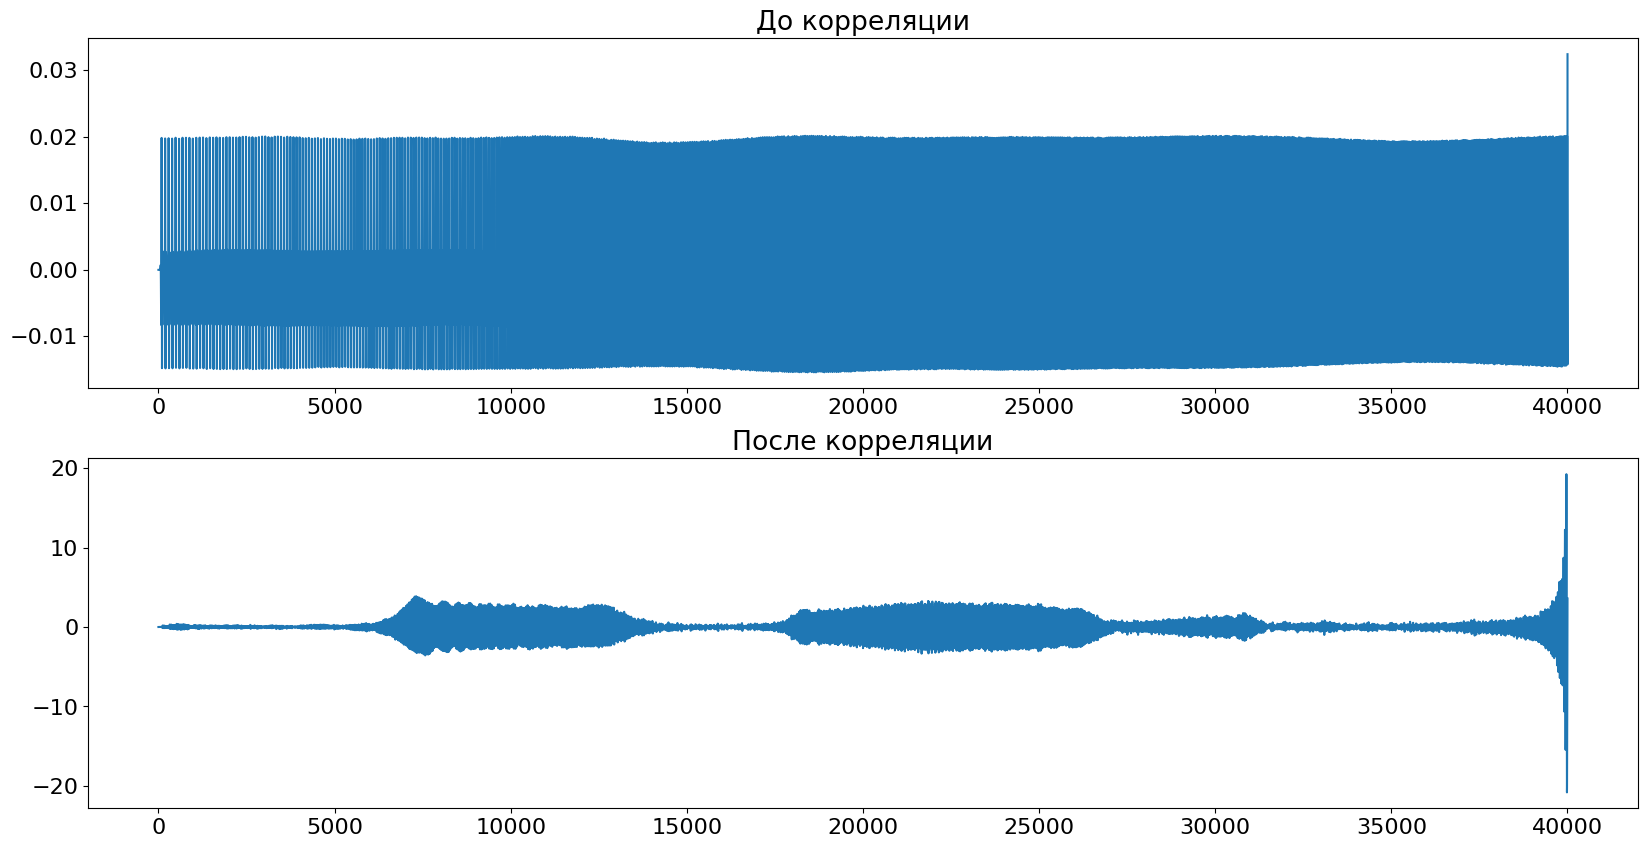

In [32]:
fig, axs = plt.subplots(2,1, figsize = (20,10))
axs[0].plot(data[:,10])
axs[0].set_title("До корреляции")
axs[1].plot(np.correlate(data[:,10], sweep, mode='full')[:data[:,10].shape[0]])
axs[1].set_title("После корреляции")
fig.tight_layout

In [34]:
split = np.arange(int(1000/dt), data.shape[0]- int(1000/dt), int(1000/dt))
data_s = np.split(data, split)
sweep_s = np.split(sweep, split)

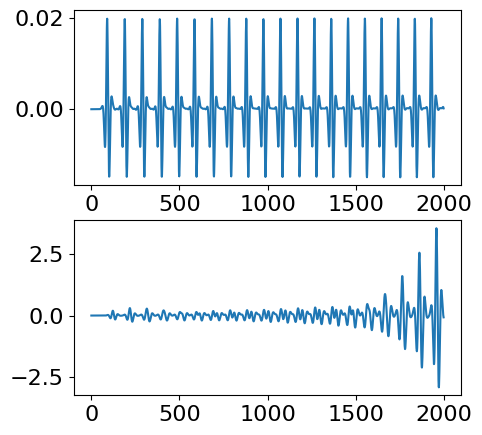

In [18]:
fig, axs = plt.subplots(2,1, figsize = (5,5))
axs[0].plot(data_s[0][:,10])
axs[1].plot(np.correlate(data_s[0][:,10], sweep_s[0], mode='full')[:data_s[0][:,10].shape[0]])

In [41]:
data_s[0]

array([[-0.        ,  0.        , -0.        , ...,  0.        ,
        -0.        , -0.        ],
       [-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        ,  0.        ],
       [-0.        , -0.        , -0.        , ..., -0.        ,
        -0.        ,  0.        ],
       ...,
       [ 0.0016947 ,  0.0008567 ,  0.00039957, ..., -0.00225503,
        -0.00844315, -0.009298  ],
       [ 0.00144611,  0.00070598,  0.00032274, ..., -0.00075563,
        -0.00693794, -0.0099482 ],
       [ 0.0012195 ,  0.0005771 ,  0.00025524, ...,  0.00048929,
        -0.00523364, -0.00987793]], shape=(2000, 56), dtype=float32)

In [ ]:
data_crl=[]
for i in range(len(data_s)):
    data_crl.append(np.apply_along_axis(lambda x: np.correlate(x, sweep_s[i], mode="full")[:data_s[i].shape[0]], 0, data_s[i]))
data_crl[19] = data_crl[19][:-2,:]

In [48]:
sum_data = np.zeros_like(data_crl[0])
for arr in data_crl:
    sum_data+= arr
sum_data/=20

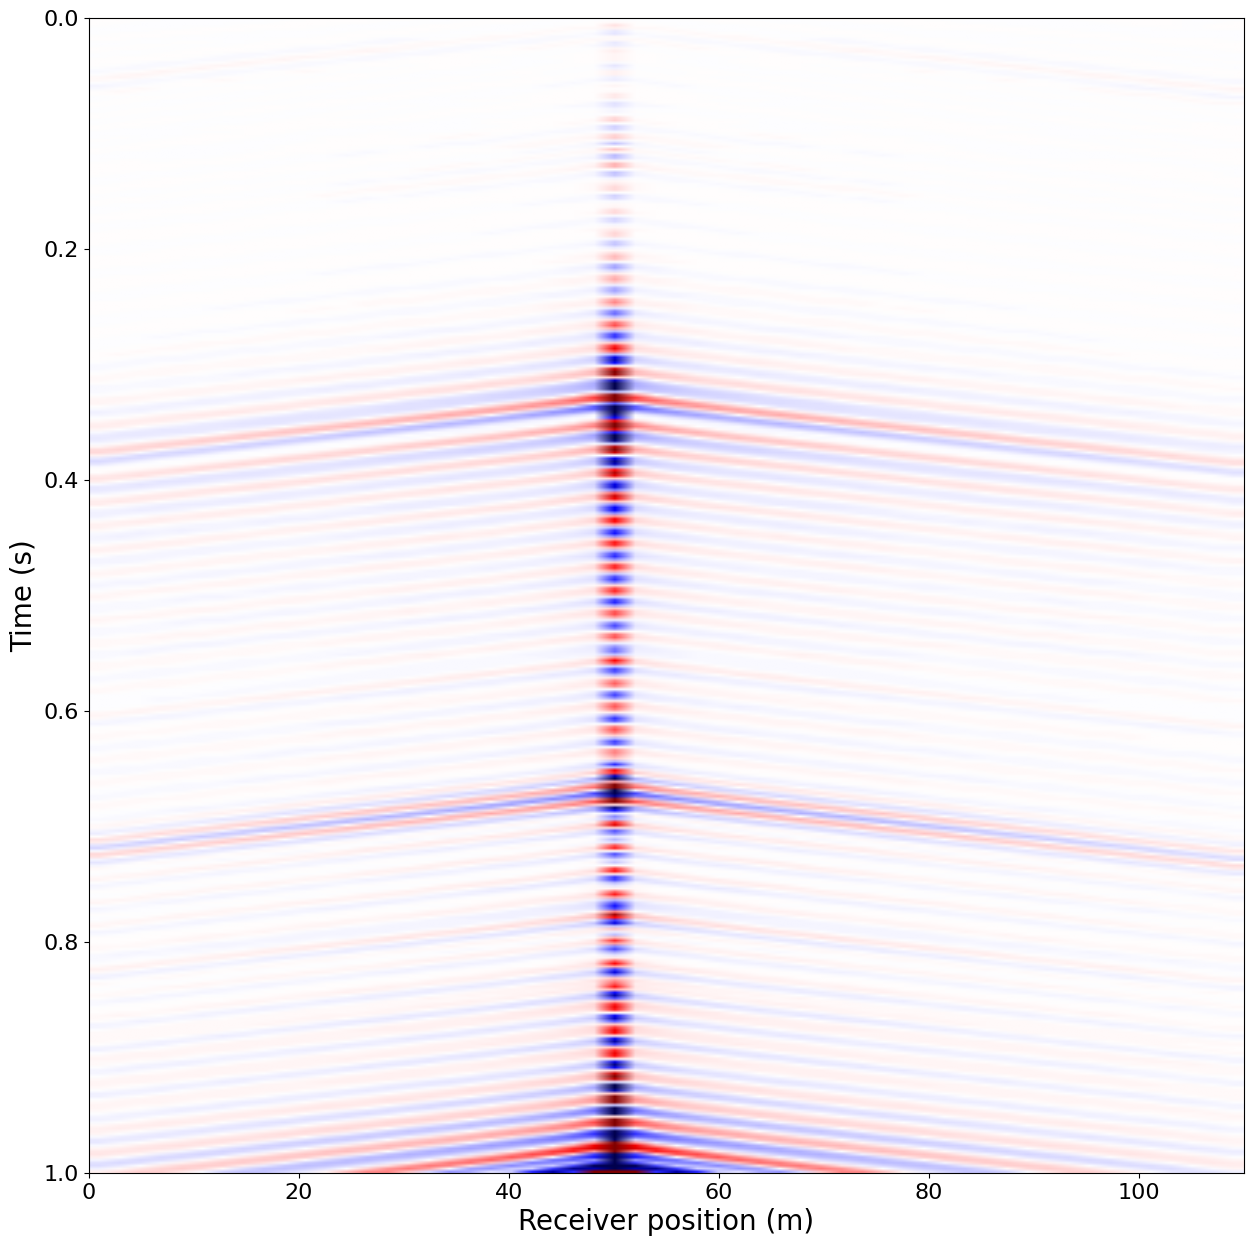

In [51]:
plot_seis_data(rec_coords, sum_data, t0=0, tn=1000)